# Baseline

#### 1- Load leaves dataset (32 classes but we use 10 classes)
#### 2- Visualise data distribution
#### 3- split data into train and test set
#### 4- Visualise each subset
#### 5- Extract descriptors using SIFT opencv
#### 6- Build dictionary
#### 7- Create visual bag of word (BOW)
#### 8- Perform classification using SVM classifier with best parameter
#### 9- perform quantitative evaluation using confusion matrix
#### 10- perform qualitative evaluation for new test leave image.


# Import all necessaries labraries

In [1]:
cd /content/drive/'My Drive'/Colab Notebooks/VAR/Leaves_Recognition

/content/drive/My Drive/Colab Notebooks/VAR/Leaves_Recognition


In [2]:
!pip install opencv-contrib-python==4.4.0.44
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from  scipy.spatial.distance import cdist
from sklearn.cluster import  KMeans
from random import  shuffle
from sklearn.model_selection import  train_test_split
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import itertools

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Extract Data by using tar command  & Load Data

In [3]:
!tar -xf Leaves.tar.bz2  

In [7]:
pathDir = './Leaves/'
classes = tuple(i for i in range(1,11))
true_labels = ['pubescent bamboo', 'Chinese horse chestnut', 'Chinese redbud', 'true indigo', 'Japanese maple', 'Nanmu',
               'castor aralia','Chinese cinnamon','goldenrain tree','Anhui Barberry']

In [8]:
classes[0]

1

In [9]:
len(classes)

10

In [10]:
len(true_labels)

10

In [11]:
def loadData(path = pathDir, resize = (256, 256)):
  labels = list()
  datasets = list()
  num_class = 0
  for _, dirs , _ in os.walk(pathDir): # get all class directory
    num_class = len(dirs)
    for subdir in dirs:
      path_folder = os.path.join(pathDir,str(subdir) + '/')
      for filename in os.listdir(path_folder):
        img =  cv2.imread(path_folder + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, resize)
        datasets.append(img)
        labels.append(subdir)
    break
  
  datasets = np.array(datasets)
  labels = np.array(labels)
  print('Leaves datset of {} images with {} labels.'.format(len(datasets),num_class))

  return datasets, labels

In [12]:
datasets, labels = loadData(path=pathDir, resize = (800, 800))

Leaves datset of 616 images with 10 labels.


In [13]:
datasets.shape

(616, 800, 800, 3)

In [14]:
labels.shape

(616,)

# Data distribution visualisation

In [15]:
def graph_bar(data = None, xlabel = None,  ylabel = None, title = None, _width = 0.9):
  n_labels, index, counts_occurences = np.unique(data, return_counts=True, return_inverse=True)
  
  fig = plt.figure(figsize = (10, 5)) 
  plt.bar(n_labels, counts_occurences, color='steelblue', width = _width) 
    
  plt.xlabel(xlabel) 
  plt.ylabel(ylabel) 
  plt.title(title) 
  plt.show() 

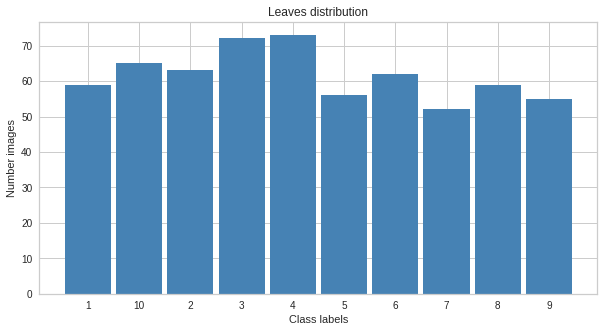

In [16]:
graph_bar(data = labels, xlabel = "Class labels",  ylabel = "Number images", title = "Leaves distribution")

# Split datasets

In [17]:
X_train,  X_test, Y_train, Y_test = train_test_split(datasets, labels, train_size=0.7, test_size=0.3, random_state=10)

In [18]:
print("Train & labels shape: {}, {}\nTest & labels shape: {}, {}".format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Train & labels shape: (431, 800, 800, 3), (431,)
Test & labels shape: (185, 800, 800, 3), (185,)


# Overview some leaves samples

In [19]:
def displaySample(data = None, labels = None, nb_line = None,nb_columns = None):
  fig, ax = plt.subplots(nb_columns, nb_line, sharex=True, sharey=True, figsize=(10,10))
  k = 0
  for i in range(nb_line):
    for j in range(nb_columns):
      ax[i,j].imshow(data[j + k], cmap="gray")
      ax[i,j].set_title('class_' + labels[j + k])
      
    k = k + nb_columns

  plt.show()

#### Display some train leaves samples

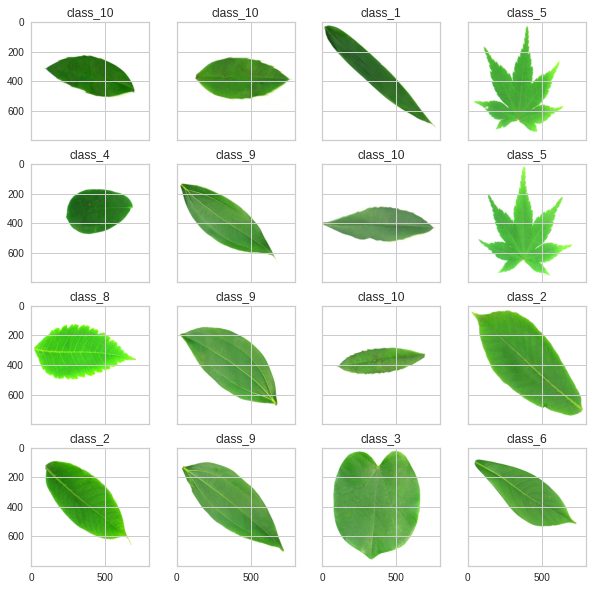

In [20]:
displaySample(data=X_train, labels= Y_train, nb_line=4, nb_columns=4)

#### Display some test leaves samples

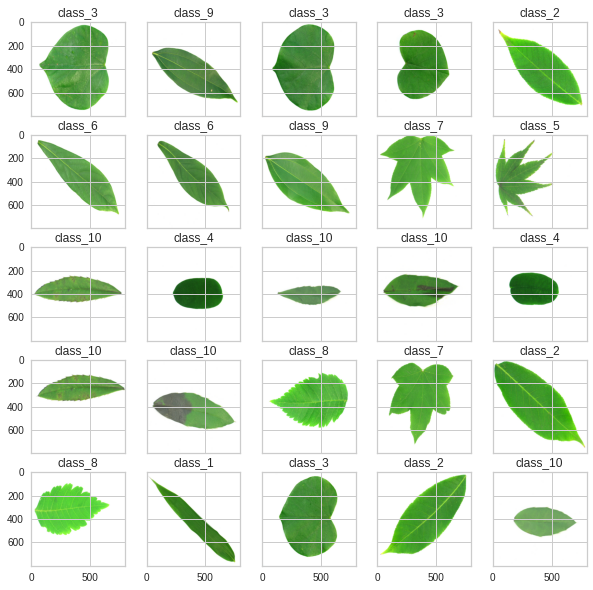

In [21]:
displaySample(data=X_test, labels=Y_test, nb_line=5, nb_columns=5)

# Features extractions 
## using SIFT descriptors
#### Compute image descriptors using SIFT avaible in opencv.
#### First initialize SIFT object, then detect and compute descriptor of each keypoint.

In [22]:
def siftDescriptors(data = None):
  sift = cv2.xfeatures2d.SIFT_create()
  data_descriptors = list()
  n_desc_list = list() # contains each descriptors lenght
  for i, img in enumerate(data):
    kp, desc = sift.detectAndCompute(img, None)
    data_descriptors.append(desc)
    n_desc_list.append(len(kp))

  return data_descriptors, n_desc_list

In [23]:
train_descriptors, n_desc_list = siftDescriptors(data=X_train)

In [24]:
len(train_descriptors)

431

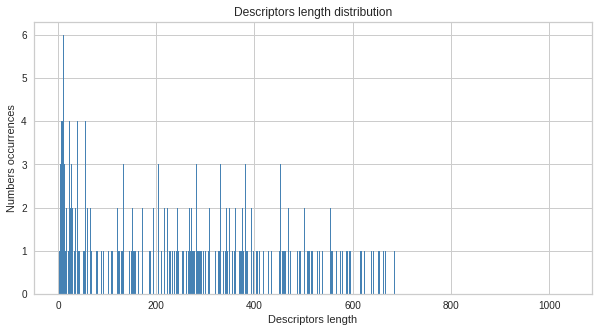

In [25]:
graph_bar(data = n_desc_list, xlabel = "Descriptors length",  ylabel = "Numbers occurrences", title = "Descriptors length distribution",  _width = 1)

# Building dictionary

#### First build vector of all descriptor of train

In [26]:
all_train_descriptors = []
for descriptors in train_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_train_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_train_descriptors)))

Total number of descriptors: 116863


#### Build the Bag of Words (BOW), using kMeans clustering method

In [27]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []
    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_
    return bow_dict

##### __step__1 : Find best number of clusters, using Elbod method

###### Here using KElbowVisualizer from yellowbrick cluster module.
###### First initialize model using kmeans clustering algorithm, then fit with all train descriptors and visualize results.

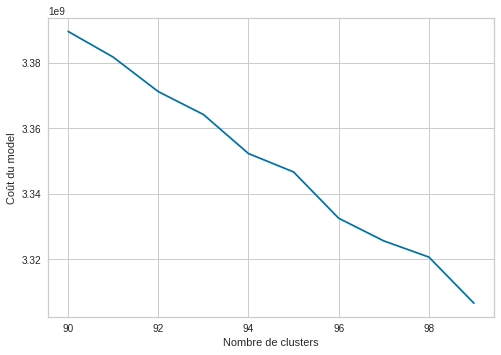

In [28]:
list_inerties = []
k_range = range(90, 100)
for k in k_range:
    model = KMeans(n_clusters=k).fit(all_train_descriptors)
    list_inerties.append(model.inertia_)

plt.plot(k_range, list_inerties)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût du model')
plt.show()

#### __step__2 : Build BOW with the best number of cluster

In [29]:
num_clusters = 96
if not os.path.isfile('bow_dictionary' + str(num_clusters) +'.pkl'):
    BoW = kmeans_bow(all_train_descriptors, num_clusters)    
    pickle.dump(BoW, open('bow_dictionary' + str(num_clusters) +'.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary' + str(num_clusters) +'.pkl', 'rb'))
print(len(BoW))
print(len(BoW[0]))

96
128


# Features vectors construction with the obtained BoW model

#### Here we create a data structure like DTM for a given set descriptors over the BOW

In [30]:
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []
    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters) # <=> features=np.zeros(num_clusters,dtype=int)        
        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)            
            argmin = np.argmin(distance, axis=1)            
            for j in argmin:
                features[j] += 1
        X_features.append(features)
    return X_features

#### Create DTM for train set

In [31]:
X_train = create_features_bow(train_descriptors, BoW, num_clusters)
X_train = np.array(X_train)
print('Training data ')
print("train data: ",X_train.shape)
print("train label: ", Y_train.shape)

Training data 
train data:  (431, 96)
train label:  (431,)


#### Create DMT for test set

In [32]:
test_descriptors, n_test_desc_list = siftDescriptors(data=X_test)
X_test = create_features_bow(test_descriptors, BoW, num_clusters)
X_test = np.array(X_test)
print('Testing data ')
print("test data: ",X_test.shape)
print("test label: ", Y_test.shape)

Testing data 
test data:  (185, 96)
test label:  (185,)


##### Visualize descriptors distribution

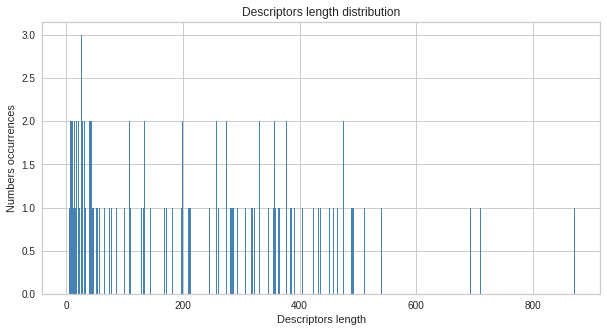

In [33]:
graph_bar(data = n_test_desc_list, xlabel = "Descriptors length",  ylabel = "Numbers occurrences", title = "Descriptors length distribution")

# Classification using SVM classifier

#### __step__1 Using gridSearch for checking the best parameter

In [34]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [35]:
svc_clf = GridSearchCV(
        SVC(), tuned_parameters
    )
 
svc_clf.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [37]:
print("Best parameters: ",svc_clf.best_params_)

Best parameters:  {'C': 1, 'kernel': 'linear'}


In [38]:
# afficher les resultats pour chaque hyperparamètres
for mean, std, params in zip(svc_clf.cv_results_['mean_test_score'],
                             svc_clf.cv_results_['std_test_score'],
                             svc_clf.cv_results_['params']):
    print ("\t accuracy = %0.3f (+/-%0.3f) for %s" %(mean, std*2, params))

	 accuracy = 0.951 (+/-0.065) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
	 accuracy = 0.812 (+/-0.028) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
	 accuracy = 0.970 (+/-0.048) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
	 accuracy = 0.956 (+/-0.045) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
	 accuracy = 0.972 (+/-0.041) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
	 accuracy = 0.977 (+/-0.033) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
	 accuracy = 0.974 (+/-0.034) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
	 accuracy = 0.981 (+/-0.024) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
	 accuracy = 0.984 (+/-0.019) for {'C': 1, 'kernel': 'linear'}
	 accuracy = 0.984 (+/-0.019) for {'C': 10, 'kernel': 'linear'}
	 accuracy = 0.984 (+/-0.019) for {'C': 100, 'kernel': 'linear'}
	 accuracy = 0.984 (+/-0.019) for {'C': 1000, 'kernel': 'linear'}


#### __step__2 Model evaluate on train and test set[link text](https://)

In [39]:
print('Train evaluation, score: {}\n\nTest evaluation, score: {} '.format(svc_clf.score(X_train, Y_train), svc_clf.score(X_test, Y_test)))

Train evaluation, score: 1.0

Test evaluation, score: 1.0 


#### __step__3 Model predict & Detail classification report & confusion matrix

In [40]:
y_pred = svc_clf.predict(X_test)

In [41]:
y_pred

array(['3', '9', '3', '3', '2', '6', '6', '9', '7', '5', '10', '4', '10',
       '10', '4', '10', '10', '8', '7', '2', '8', '1', '3', '2', '10',
       '1', '8', '9', '9', '7', '7', '1', '4', '6', '10', '4', '1', '10',
       '6', '1', '9', '5', '9', '6', '6', '9', '4', '5', '9', '9', '3',
       '1', '2', '2', '1', '6', '9', '3', '9', '10', '8', '8', '10', '6',
       '3', '3', '4', '3', '9', '8', '6', '5', '8', '5', '10', '8', '4',
       '8', '5', '1', '1', '10', '4', '10', '8', '3', '3', '1', '6', '2',
       '9', '5', '4', '9', '2', '7', '5', '2', '10', '7', '6', '4', '6',
       '4', '2', '9', '4', '5', '4', '1', '4', '1', '5', '3', '10', '9',
       '8', '4', '3', '3', '1', '5', '3', '1', '6', '3', '10', '10', '3',
       '8', '2', '2', '2', '2', '2', '1', '6', '2', '1', '3', '4', '4',
       '1', '10', '1', '1', '2', '8', '10', '5', '6', '7', '8', '4', '4',
       '4', '3', '5', '5', '9', '3', '1', '2', '3', '1', '4', '9', '4',
       '10', '9', '4', '4', '10', '4', '2', '1', '

##### Classification report

In [42]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        23
          10       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        19

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185



#### Confusion matrix

In [43]:
############## Draw confusion matrix

#@reuse from  Dennis Trimarchi github

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [44]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(Y_test, y_pred )
cf_matrix

array([[23,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 21,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 18,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 28,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 14,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 15,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 18,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 19]])

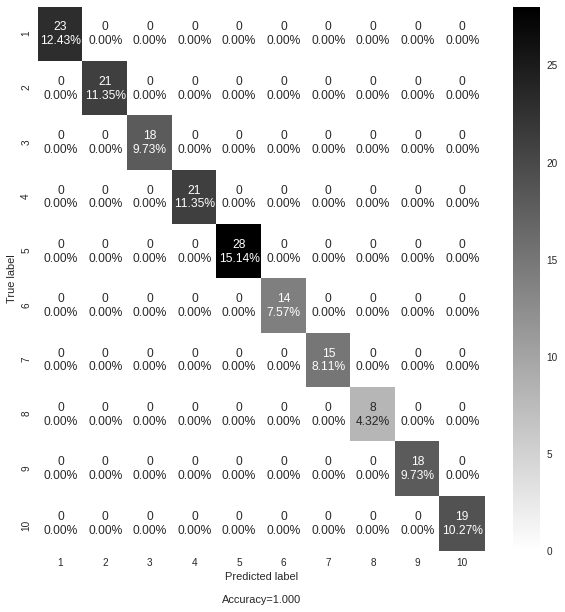

In [45]:
_labels = ['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf_matrix, group_names=_labels,categories=classes, figsize=(10,10), cmap='binary')

# Qualitative evaluation of trained model

In [144]:
def predictLeave(name_file = None):
  path = './samples/' + name_file + '.jpeg'
  new_image_descriptors = None
  new_image_features = None
  img = cv2.imread(path)
  img = cv2.resize(img, (800, 800))
  test_list = []
  test_list.append(img)
  new_image_descriptors, _ = siftDescriptors(data=test_list)
  new_image_features = create_features_bow(new_image_descriptors, BoW, num_clusters)
  new_image_features = np.array(new_image_features)

  y_pred = svc_clf.predict(new_image_features)
  
  # display results
  fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,6))

  ax[0].imshow(img, cmap="gray")
  ax[0].set_title('Original image')
  _label = [i for i in labels]
  
  index = _label.index(y_pred)
  n = int(y_pred[0]) - 1
  
  ax[1].imshow(datasets[index], cmap="gray")
  ax[1].set_title('predicted class: {}, {} '.format(y_pred[0], true_labels[n]))

  plt.show()

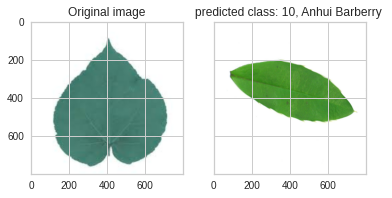

In [145]:
predictLeave(name_file = 'test1')

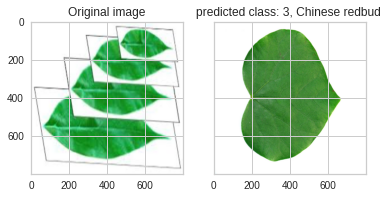

In [146]:
predictLeave(name_file = 'test2')

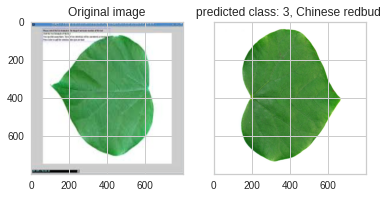

In [147]:
predictLeave(name_file = 'test3')

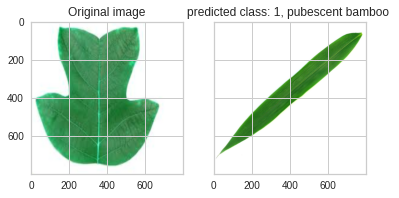

In [148]:
predictLeave(name_file = 'test4')

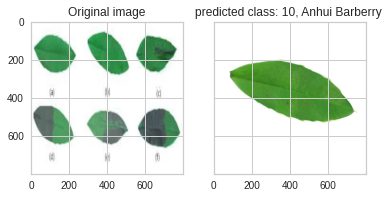

In [149]:
predictLeave(name_file = 'test5')

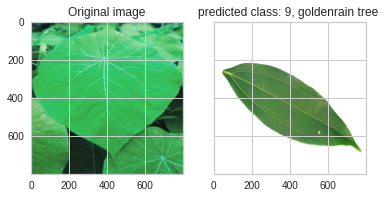

In [150]:
predictLeave(name_file = 'test6')

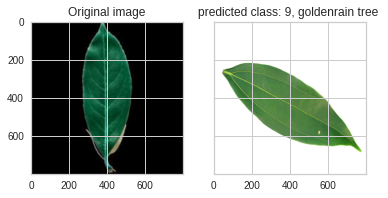

In [151]:
predictLeave(name_file = 'test7')